In [1]:
# Distributed Custom Training using TensorFlow

# The tf.distribute.Strategy API provides an abstraction for distributing your training
# across multiple processing units. The goal is to allow users to enable distributed
# training using existing models and training code, with minimal changes.

In [2]:
# Import TensorFlow
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import os
print(tf.__version__)

2.13.0


In [3]:
default_strategy = tf.distribute.get_strategy()
default_strategy

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
# We will be looking one of the distributed training method.
# The tf.distribute.MirroredStrategy, which does in-graph replication with synchronous
# training on many GPUs on one machine. It works best with tf.function
# Efficient all-reduce algorithms are used to communicate the variable updates across the devices

# By default, it uses NVIDIA NCCL (NVIDIA Collective Communications Library) as
# the all-reduce implementation.

GPU_devices_list = tf.config.list_physical_devices('GPU')

if GPU_devices_list:
  if len(GPU_devices_list)==1:
    # strategy to place all variables and computation on a single specified device
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
  else:
    strategy = tf.distribute.MirroredStrategy()

  # We can provide other cross device communication method too
  """
  mirrored_strategy = tf.distribute.MirroredStrategy(
    cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
    """
else:  # use default strategy like running on CPU
  strategy = tf.distribute.get_strategy()

print(strategy)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 1


In [6]:
# Loads the standard MNIST dataset into a tf.data.Dataset
datasets, info = tfds.load(name='mnist', with_info=True, as_supervised=True)

mnist_train, mnist_test = datasets['train'], datasets['test']

num_train_examples = info.splits['train'].num_examples
num_test_examples = info.splits['test'].num_examples
print(num_train_examples)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
60000


In [7]:
# Defining Hyperparameters

BUFFER_SIZE = 10000
# batch size
BATCH_SIZE_PER_REPLICA = 64
# batch size (also called global_batch_size) when training on multiple GPUs
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

EPOCH = 20
BATCH_SIZE

64

In [8]:
# Data Augmentation methods
def scaling(image, label):
  image = tf.cast(image, tf.float32)
  image = image/127.5 - 1
  return image, label


In [9]:
# create input dataset pipeline
def create_input_pipeline(mnist_train, mnist_test):
  train_dataset = mnist_train.map(scaling).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
  eval_dataset = mnist_test.map(scaling).batch(BATCH_SIZE)

  # Distribute input data to available devices
  train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
  eval_dist_dataset = strategy.experimental_distribute_dataset(eval_dataset)

  return train_dist_dataset, eval_dist_dataset

In [10]:

# define the simple Convolution model funtion
class SimpleConvModel(keras.Model):

  def __init__(self, IMG_SIZE=28, output_classes=10, **kwargs):
    super().__init__(**kwargs)
    self.regularizer = keras.regularizers.L2(1e-5)
    self.conv1 = keras.layers.Conv2D(32, 3, activation='relu',
                                     input_shape=(IMG_SIZE, IMG_SIZE, 1),
                                     kernel_regularizer=self.regularizer)
    self.maxpool1 = keras.layers.MaxPooling2D()
    self.conv2 = keras.layers.Conv2D(64, 3, activation='relu',
                                     kernel_regularizer=self.regularizer)
    self.maxpool2 = keras.layers.MaxPooling2D()
    self.flatten = keras.layers.Flatten()
    self.dense1 = keras.layers.Dense(64, activation='relu')
    self.dense2 = keras.layers.Dense(output_classes)

  def call(self, input):
    x = self.conv1(input)
    x = self.maxpool1(x)
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.dense2(x)
    return x


def create_model(IMG_SIZE):
  conv_model = tf.keras.Sequential([
      tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
      tf.keras.layers.MaxPooling2D(),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(64, activation='relu'),
      tf.keras.layers.Dense(10)
  ])
  return conv_model

In [11]:
# Create a checkpoint directory to store the checkpoints.
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

In [12]:
# Defining the Loss function and Metrics for training is the most important part of the
# custom training with tensorflow distributed strategy

"""
Loss function consist of two parts:
1. Prediction Loss: It measures how far off the model's predictions are from the
   training labels for a batch of training examples.

2. Regularization Loss: It is added to steer the model away from overfitting the
   training data. E.g : L2 regularization, which adds a small fixed multiple of the
   sum of squares of all model weights, independent of the number of examples.
"""

# For training on a single machine with a single GPU/CPU, this works as follows:

# 1. The prediction loss is computed for each example in the batch, summed across
#    the batch, and then divided by the batch size.
# 2. The regularization loss is added to the prediction loss.
# 3. The gradient of the total loss is computed w.r.t. each model weight, and the
#    optimizer updates each model weight from the corresponding gradient.


# For Training on multiple GPU/CPUs of single machine :
"""
1. Each replica computes the prediction loss for all examples distributed to it,
   sums up the results and divides them by num_replicas_in_sync * BATCH_SIZE_PER_REPLICA,
   or equivently, GLOBAL_BATCH_SIZE.

2. Each replica compues the regularization loss and divides them by num_replicas_in_sync.

3. Each replica computes the loss from the training examples it gets and computes the
   gradients of the loss w.r.t. each model weight. The optimizer takes care that these
   gradients are summed up across replicas before using them to update the copies
   of the model weights on each replica.
"""



'\n1. Each replica computes the prediction loss for all examples distributed to it, \n   sums up the results and divides them by num_replicas_in_sync * BATCH_SIZE_PER_REPLICA, \n   or equivently, GLOBAL_BATCH_SIZE.\n\n2. Each replica compues the regularization loss and divides them by num_replicas_in_sync.\n\n3. Each replica computes the loss from the training examples it gets and computes the \n   gradients of the loss w.r.t. each model weight. The optimizer takes care that these \n   gradients are summed up across replicas before using them to update the copies \n   of the model weights on each replica.\n'

In [13]:
# Points to remember while calculating loss in custom training

# 1. If you're writing a custom training loop, as in this tutorial, you should sum
#    the per-example losses and divide the sum by the global batch size using
#    tf.nn.compute_average_loss, which takes the per-example losses and optional
#    sample weights as arguments and returns the scaled loss.

# 2. If using tf.keras.losses classes (as in the example below), the loss reduction
#    needs to be explicitly specified to be one of NONE or SUM. The default AUTO
#    and SUM_OVER_BATCH_SIZE are disallowed outside Model.fit.

# 3. A custom training loop for a model with a non-empty list of Model.losses
#    (e.g., weight regularizers), you should sum the tf.nn.scale_regularization_loss
#    up and divide the sum by the number of replicas.

In [14]:
# define optimizer and metrics inside
# Optimizer, Metrics definition should be within the scope.

with strategy.scope():

  loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction= tf.keras.losses.Reduction.NONE)

  def compute_loss(y_true, y_pred, model_losses):
    per_example_loss = loss_fn(y_true, y_pred)  # prediction loss for single example
    avg_loss = tf.nn.compute_average_loss(
        per_example_loss,
        global_batch_size=BATCH_SIZE) # loss/global_batch_size

    if model_losses:
      # adding regularization loss
      avg_loss = avg_loss + tf.nn.scale_regularization_loss(tf.math.add_n(model_losses))

    return avg_loss

In [15]:
# Some Special cases while calculating losses in distributed custom training

# 1. Input batches shorter than GLOBAL_BATCH_SIZE create bad results.

# solution:
"""
Dataset.repeat().batch(): This pipeline operation is used to allow batches to span
 epoch boundaries. It repeats the dataset indefinitely and batches it accordingly.
 It's a common practice to ensure that each training example is seen at least once
 in each training epoch.

Dataset.batch(drop_remainder=True): This operation batches the data but drops the
 last few examples if they don't form a complete batch. This is often used when
 maintaining a notion of epochs is important.
"""

# 2. Consider a classification task where you have input images, and you want to
#    perform pixel-wise classification. In this case, each pixel in an image can
#    belong to one of several classes, resulting in multi-dimensional labels.
"""
With predictions of shape (batch_size, H, W, n_classes) and labels of shape (batch_size, H, W)
We need to update per_example_loss like:
per_example_loss /= tf.cast(tf.reduce_prod(tf.shape(labels)[1:]), tf.float32)

 * tf.shape(labels)[1:]: This gets the shape of the labels tensor excluding the first
   dimension (batch size), resulting in a shape of (H, W).

 * tf.reduce_prod(...): This computes the product of all elements in the tensor, which
   gives you the total number of predictions in each example (H * W).
"""

# Note: Loss functions in tf.losses/tf.keras.losses typically return the average over
#       the last dimension of the input. The loss classes wrap these functions.

'\nWith predictions of shape (batch_size, H, W, n_classes) and labels of shape (batch_size, H, W)\nWe need to update per_example_loss like: \nper_example_loss /= tf.cast(tf.reduce_prod(tf.shape(labels)[1:]), tf.float32)\n\n * tf.shape(labels)[1:]: This gets the shape of the labels tensor excluding the first \n   dimension (batch size), resulting in a shape of (H, W).\n\n * tf.reduce_prod(...): This computes the product of all elements in the tensor, which \n   gives you the total number of predictions in each example (H * W).\n'

In [16]:
# Defining metrics for testing and training (should be under scope)

with strategy.scope():

  test_loss = tf.keras.metrics.Mean(name="test loss")

  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="train accuracy")

  test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name="test accuracy")

  # Note: .result() can be called to get accumulated value.

In [17]:
from tensorflow.python.training import optimizer
# Define Optimizer and Model within the scope

with strategy.scope():

  optimizer_fn = tf.keras.optimizers.Adam(learning_rate=0.002)

  model = SimpleConvModel(28, 10)

  # checkpoint for storing best model trained and its weights as Fault tolerance.
  checkpoint = tf.train.Checkpoint(optimizer=optimizer_fn, model=model)

In [18]:
# Define training and testing step

def train_step(input_data):
  image, label = input_data

  with tf.GradientTape() as tape:
    y_pred = model(image, training=True)
    loss = compute_loss(label, y_pred, model.losses)

  grad = tape.gradient(loss, model.trainable_variables)
  optimizer_fn.apply_gradients(zip(grad, model.trainable_variables))

  train_accuracy.update_state(label, y_pred)

  return loss


def test_step(input_data):

  image, label = input_data

  y_pred = model(image, training=False)
  t_loss = loss_fn(label, y_pred)

  test_loss.update_state(t_loss)
  test_accuracy.update_state(label, y_pred)



In [19]:
# strategy `run` replicates the provided computation and runs it
# with the distributed input.

@tf.function
def distributed_train_step(dataset_inputs):
  per_replica_losses = strategy.run(train_step, args=(dataset_inputs,))

  total_losses = strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,axis=None)
  return total_losses


@tf.function
def distributed_test_step(dataset_inputs):
  return strategy.run(test_step, args=(dataset_inputs,))

In [20]:
# Custom training cycle for epochs

def run_training():

  # Training LOOP steps
  training_losses = []
  testing_losses = []
  train_dist_dataset, test_dist_dataset = create_input_pipeline(mnist_train, mnist_test)

  for epoch in range(EPOCH):
    total_losses = 0.0
    num_batches = 0
    cnt = 0

    for x in train_dist_dataset:
      if cnt%100 == 0:
        print ('=', end='')
      cnt += 1
      total_losses = total_losses + distributed_train_step(x)
      num_batches = num_batches + 1

    print("number of batches : ", num_batches)
    print('\n')
    training_losses.append(total_losses/num_batches)

    # Testing LOOP steps starts now

    for x in test_dist_dataset:
      distributed_test_step(x)

    if epoch % 5 == 0:
      checkpoint.save(checkpoint_prefix)

    template = ("Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, "
              "Test Accuracy: {}")
    print(template.format(epoch + 1, total_losses, train_accuracy.result() * 100,
                          test_loss.result(),test_accuracy.result() * 100))

    testing_losses.append(test_loss.result())
    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()

  return training_losses, testing_losses



In [21]:
training_losses_list, testing_losses_list = run_training()

==========number of batches :  938


Epoch 1, Loss: 119.29309844970703, Accuracy: 96.0133285522461, Test Loss: 0.04106125980615616, Test Accuracy: 98.65999603271484
==========number of batches :  938


Epoch 2, Loss: 40.4599723815918, Accuracy: 98.66333770751953, Test Loss: 0.03612544760107994, Test Accuracy: 98.80999755859375
==========number of batches :  938


Epoch 3, Loss: 29.760950088500977, Accuracy: 99.05333709716797, Test Loss: 0.032564401626586914, Test Accuracy: 98.8499984741211
==========number of batches :  938


Epoch 4, Loss: 22.923574447631836, Accuracy: 99.2550048828125, Test Loss: 0.039806149899959564, Test Accuracy: 98.8699951171875
==========number of batches :  938


Epoch 5, Loss: 19.378915786743164, Accuracy: 99.39666748046875, Test Loss: 0.031358323991298676, Test Accuracy: 99.1199951171875
==========number of batches :  938


Epoch 6, Loss: 16.43707847595215, Accuracy: 99.51333618164062, Test Loss: 0.03951571509242058, Test Accuracy: 98.97000122070312
=========

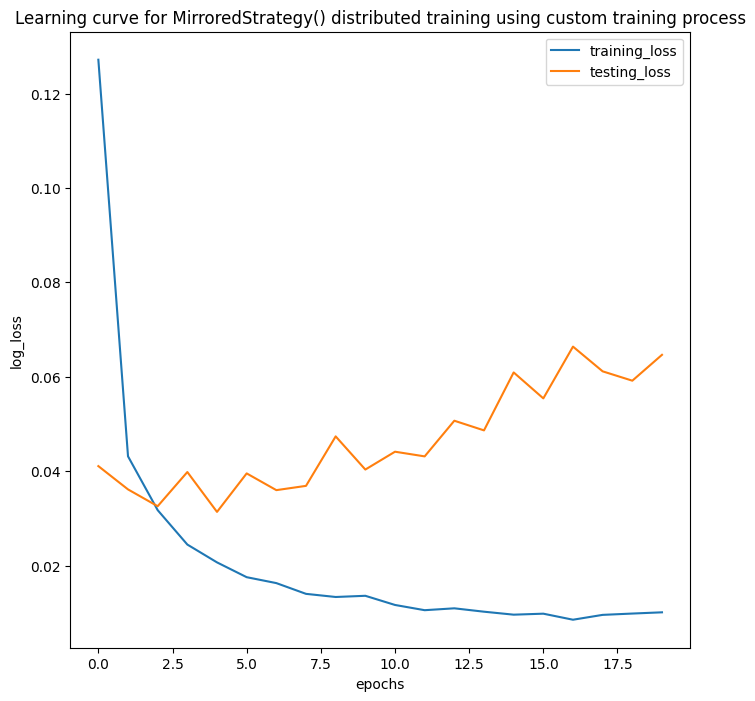

In [22]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.title("Learning curve for MirroredStrategy() distributed training using custom training process")
plt.plot(training_losses_list, label="training_loss")
plt.plot(testing_losses_list, label="testing_loss")
plt.xlabel("epochs")
plt.ylabel("log_loss")
plt.legend()

In [23]:
# Define Learning Rate Scheduler
def decay(epoch):
  if epoch < 3:
    return 1e-3
  elif epoch >= 3 and epoch < 7:
    return 1e-4
  else:
    return 1e-5

In [24]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

In [28]:
# Restore the latest checkpoint and test
# A model checkpointed with a tf.distribute.Strategy can be restored with or without a strategy.

eval_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
      name='eval_accuracy')

new_model = SimpleConvModel()
new_optimizer = tf.keras.optimizers.Adam()

checkpoint = tf.train.Checkpoint(optimizer=new_optimizer, model=new_model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


@tf.function
def eval_step(images, labels):
  predictions = new_model(images, training=False)
  eval_accuracy(labels, predictions)

In [25]:
# Saving and Loading model in distribute strategy
"""
There are two kinds of APIs for saving and loading a Keras model:
1. high-level (tf.keras.Model.save and tf.keras.models.load_model) # (.keras zip archive format)
2. low-level (tf.saved_model.save and tf.saved_model.load).   # (TF SavedModel format)

Note that you can get a Keras model back only if you saved a Keras model.

Note: In custom training, Make sure custom classes are decorated with
 @keras.saving.register_keras_serializable() is need

"""

path = '/tmp/tf_save.keras'

# Save the entire model as a SavedModel.
model.save(path)

In [ ]:
# Loading the model
# Here, model can be loaded with or without any distributed strategy
restored_tf_model = tf.keras.models.load_model(path)

# After restoring the model, you can continue training on it, even without needing
# to call Model.compile again, since it was already compiled before saving.
# restored_tf_model.fit(train_dataset, epochs=2)

In [ ]:
# Loading model with Strategy

# Note: The strategy used here does not have to be the same strategy used before saving.
another_strategy = tf.distribute.MirroredStrategy()
with another_strategy.scope():
  restored_tf_model_ds = tf.keras.models.load_model(path)
  #restored_tf_model_ds.fit(train_dataset, epochs=2)